<a href="https://colab.research.google.com/github/GilgameshxZero/adversarial-ntks/blob/master/notebooks/tony_kernel_norm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import pandas as pd

import sklearn
from sklearn import svm

### Data generating process
$\mathsf{x}$ sampled from $\mathrm{Unif}([-2, -1] \cup [1, 2])$.
$\mathsf{y}$ is the sign of $\mathsf{x}$,
with some corruption probability of sign flip.

Alternative to try: add some noise to x and take sign.

In [ ]:
def get_data(num_samples, corrupt_prob=0.1):
    X = np.random.uniform(low=-1, high=1, size=num_samples)
    X[X <= 0] -= 1
    X[X > 0] += 1
    y = X < 0

    corrupt = np.random.random(size=num_samples) <= corrupt_prob
    y[corrupt] = ~y[corrupt]

    return X.reshape(-1, 1), y

def get_norm(clf, X, kfn):
    sX = X[clf.support_]
    K = kfn(sX, sX)
    return (clf.dual_coef_ @ K @ clf.dual_coef_.T)[0, 0] ** 0.5

def rbf_kfn(A, B, gamma):
    return sklearn.metrics.pairwise.rbf_kernel(X=A, Y=B, gamma=gamma)

### Singular values of the kernel matrix

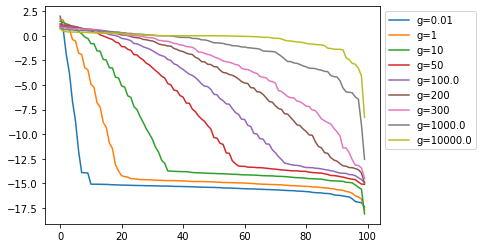

In [ ]:
np.random.seed(41)
X, y = get_data(num_samples=100, corrupt_prob=0.1)
for g in [1e-2, 1, 10, 50, 1e2, 200, 300, 1e3, 1e4]:
    K = rbf_kfn(X, X, gamma=g)
    svs = np.linalg.svd(a=K, compute_uv=False, hermitian=True)
    log_svs = np.log10(svs)
    plt.plot(log_svs, label=f"g={g}")

plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1);

### Fit SVM under different settings

In [ ]:
np.random.seed(42)

GAMMA = 1e5
KFN = lambda x, y: rbf_kfn(x, y, GAMMA)

data = []
for cp in tqdm([0, 0.02, 0.05, 0.1, 0.2]):
    for n in tqdm(range(16, 512), leave=False):
        X, y = get_data(num_samples=n, corrupt_prob=cp)

        clf = svm.SVC(kernel=KFN, C=1e12) # no regularization
        clf.fit(X, y)

        data.append(dict(
            cp=cp,
            n=n,
            min_dist=np.diff(sorted(X.flatten())).min(),
            max_dual_coef=np.abs(clf.dual_coef_).max(),
            norm=get_norm(clf, X, kfn=KFN),
            train_acc=(clf.predict(X) == y).mean(),
            gamma=GAMMA
        ))

### Results

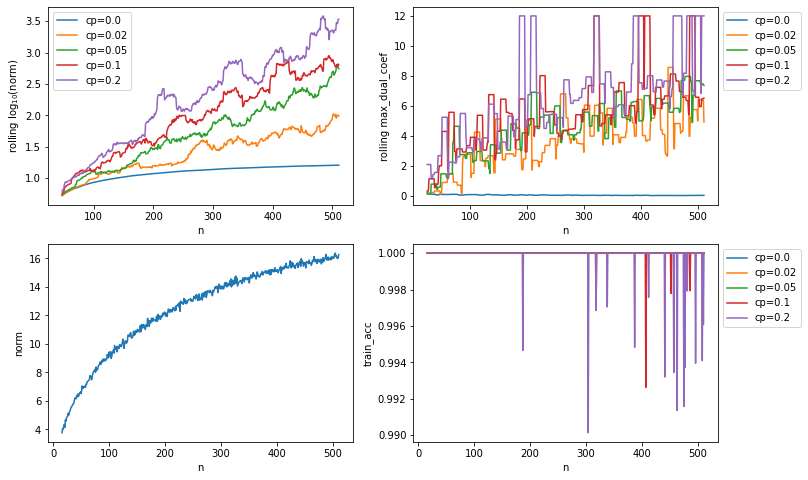

In [ ]:
df = pd.DataFrame(data).set_index("n")

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
for cp in df.cp.unique():
    #np.log10(df[df.cp == cp].norm).rolling(2).mean().plot();
    np.log10(df[df.cp == cp].norm).rolling(32).mean().plot(label=f"cp={cp}");
plt.ylabel("rolling log$_{10}$(norm)")
plt.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1);

plt.subplot(2, 2, 3)
df[df.cp == 0.0].norm.plot();
plt.ylabel("norm")

plt.subplot(2, 2, 2)
for cp in df.cp.unique():
    np.log10(df[df.cp == cp].max_dual_coef).rolling(10).max().plot(label=f"cp={cp}")
    #df.min_dist.plot(logy=True)
plt.ylabel("rolling max_dual_coef");
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1);

plt.subplot(2, 2, 4)
for cp in df.cp.unique():
    df[df.cp == cp].train_acc.plot(label=f"cp={cp}")
plt.ylabel("train_acc");
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1);

### Looking closer at no noise case

In [ ]:
np.random.seed(42)

data2 = []
for gamma in tqdm([1e-4, 1e-2, 1, 1e2, 1e4]):
    kfn = lambda x, y: rbf_kfn(x, y, gamma)
    for n in tqdm(range(16, 2048, 16), leave=False):
        X, y = get_data(num_samples=n, corrupt_prob=0)

        clf = svm.SVC(kernel=kfn, C=1e12) # no regularization
        clf.fit(X, y)

        data2.append(dict(
            cp=0,
            n=n,
            min_dist=np.diff(sorted(X.flatten())).min(),
            max_dual_coef=np.abs(clf.dual_coef_).max(),
            norm=get_norm(clf, X, kfn=kfn),
            train_acc=(clf.predict(X) == y).mean(),
            gamma=gamma
        ))

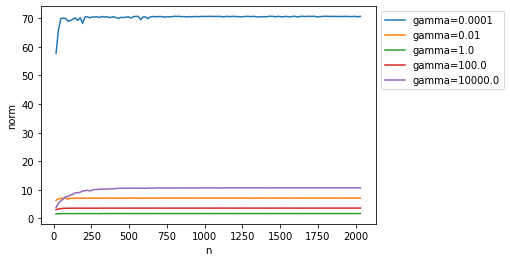

In [ ]:
df2 = pd.DataFrame(data2).set_index("n")

for gamma in df2.gamma.unique():
    #np.log10(df[df.cp == cp].norm).rolling(2).mean().plot();
    df2[df2.gamma == gamma].norm.plot(label=f"gamma={gamma}");
plt.ylabel("norm")
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1);

# Conclusions
- Norm doesn't blow up when there is no label noise.
    - See onenote notebook for proof.
- Norm blows up (exponentially) when there is more label noise.
    - Blow up is faster when more noise.
- Kernel matrix is poorly conditioned when bandwidth is large.